# Credit Scoring – Exploratory Data Analysis (EDA)

## Contexte
AfriCash Solutions est une fintech spécialisée dans l'octroi de micro-crédits
aux acteurs du secteur informel en Afrique de l’Ouest.

L’objectif de ce notebook est d’explorer les données historiques de crédit
afin d’identifier les facteurs de risque associés au défaut de paiement.

## Objectifs de l’EDA
- Comprendre la structure des données
- Mesurer le taux de défaut global
- Identifier les variables discriminantes
- Poser les bases d’un modèle de credit scoring robuste


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

In [2]:
# Adapter le chemin si nécessaire
data_path = "../data/raw/credit_risk_dataset.csv"

df = pd.read_csv(data_path)

df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
print("Shape:", df.shape)
df.info()

Shape: (32581, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


## Analyse de la variable cible

`loan_status` indique si le client a fait défaut :
- 0 : prêt remboursé
- 1 : défaut de paiement

La distribution de cette variable est critique
pour comprendre le niveau de risque global du portefeuille.

In [5]:
default_rate = df["loan_status"].mean()
print(f"Taux de défaut global : {default_rate:.2%}")

Taux de défaut global : 21.82%


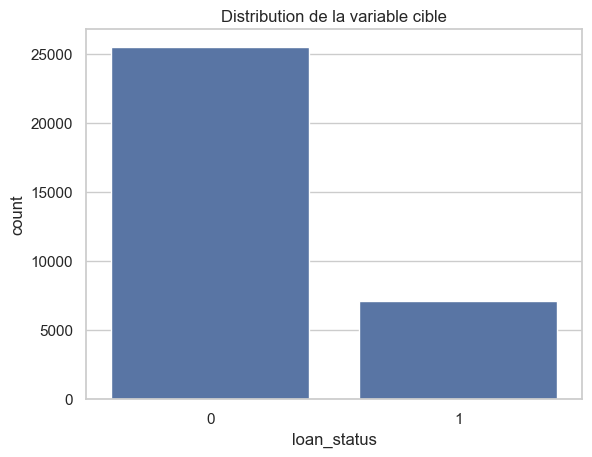

In [6]:
sns.countplot(x="loan_status", data=df)
plt.title("Distribution de la variable cible")
plt.show()

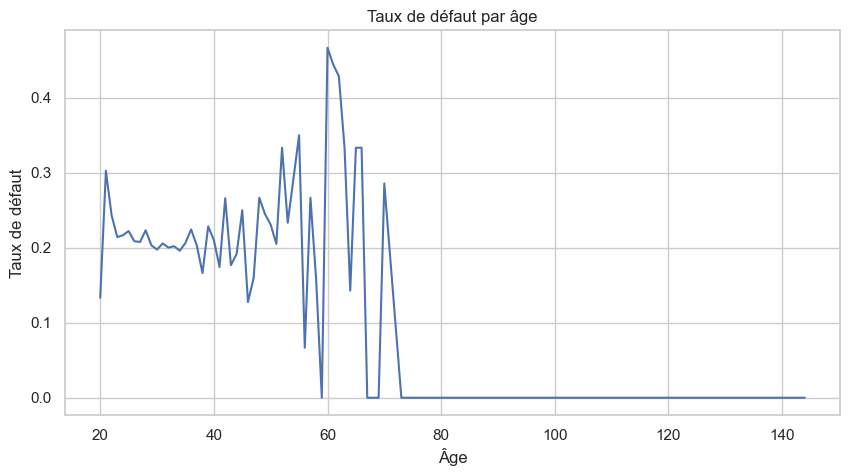

In [7]:
age_default = df.groupby("person_age")["loan_status"].mean()

plt.figure(figsize=(10,5))
plt.plot(age_default.index, age_default.values)
plt.xlabel("Âge")
plt.ylabel("Taux de défaut")
plt.title("Taux de défaut par âge")
plt.show()

C:\Users\GENERAL STORES-SARL\AppData\Local\Temp\ipykernel_30108\3237917937.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default = df.groupby("income_bin")["loan_status"].mean()


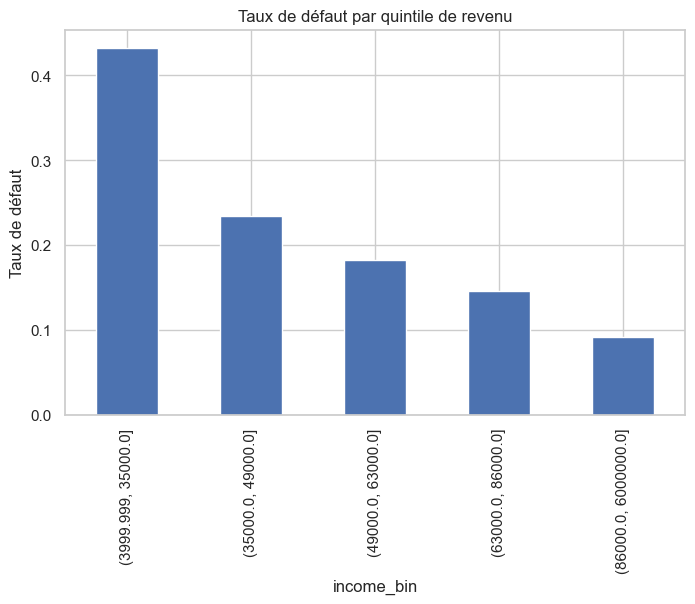

In [8]:
df["income_bin"] = pd.qcut(df["person_income"], q=5)

income_default = df.groupby("income_bin")["loan_status"].mean()

income_default.plot(kind="bar", figsize=(8,5))
plt.title("Taux de défaut par quintile de revenu")
plt.ylabel("Taux de défaut")
plt.show()

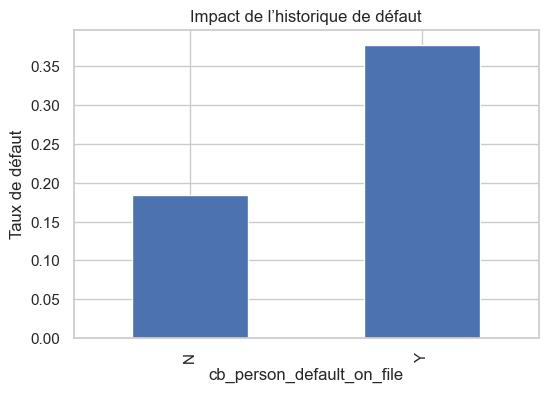

In [9]:
history_default = df.groupby("cb_person_default_on_file")["loan_status"].mean()

history_default.plot(kind="bar", figsize=(6,4))
plt.title("Impact de l’historique de défaut")
plt.ylabel("Taux de défaut")
plt.show()

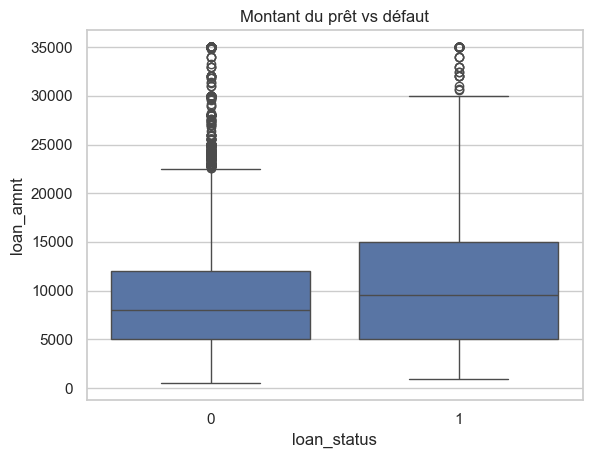

In [10]:
sns.boxplot(x="loan_status", y="loan_amnt", data=df)
plt.title("Montant du prêt vs défaut")
plt.show()

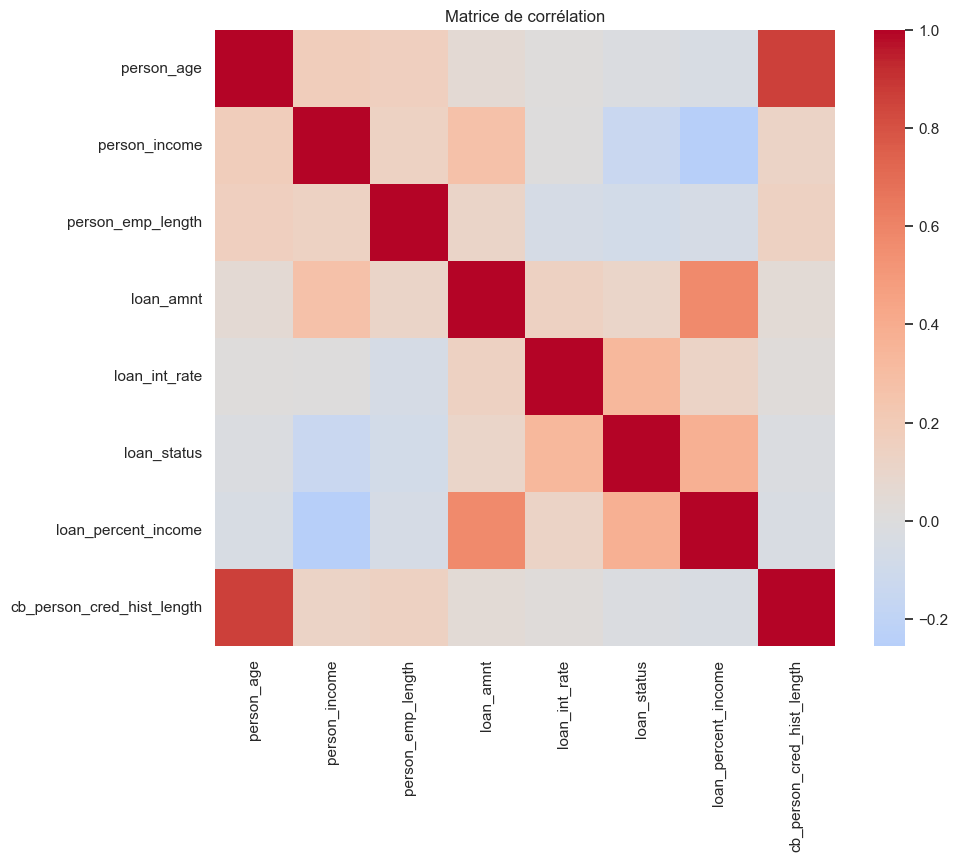

In [12]:
num_cols = df.select_dtypes(include=np.number)

plt.figure(figsize=(10,8))
sns.heatmap(num_cols.corr(), cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.show()